# InSituPy demonstration - Differential gene expression analysis

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
import scanpy as sc

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)

In [6]:
xd.load_images()
xd.load_cells()

Loading images...


In [7]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'annotations', 'regions', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connectivities', 'distances'
       boundaries
           Boundar

In [8]:
xd.import_annotations(
    files="./demo_annotations/demo_annotations.geojson",
    keys="Demo",
    scale_factor=0.2125
)

In [9]:
xd.import_regions(
    files="./demo_regions/demo_regions.geojson",
    keys="Demo",
    scale_factor=0.2125
)

### Visualize annotations
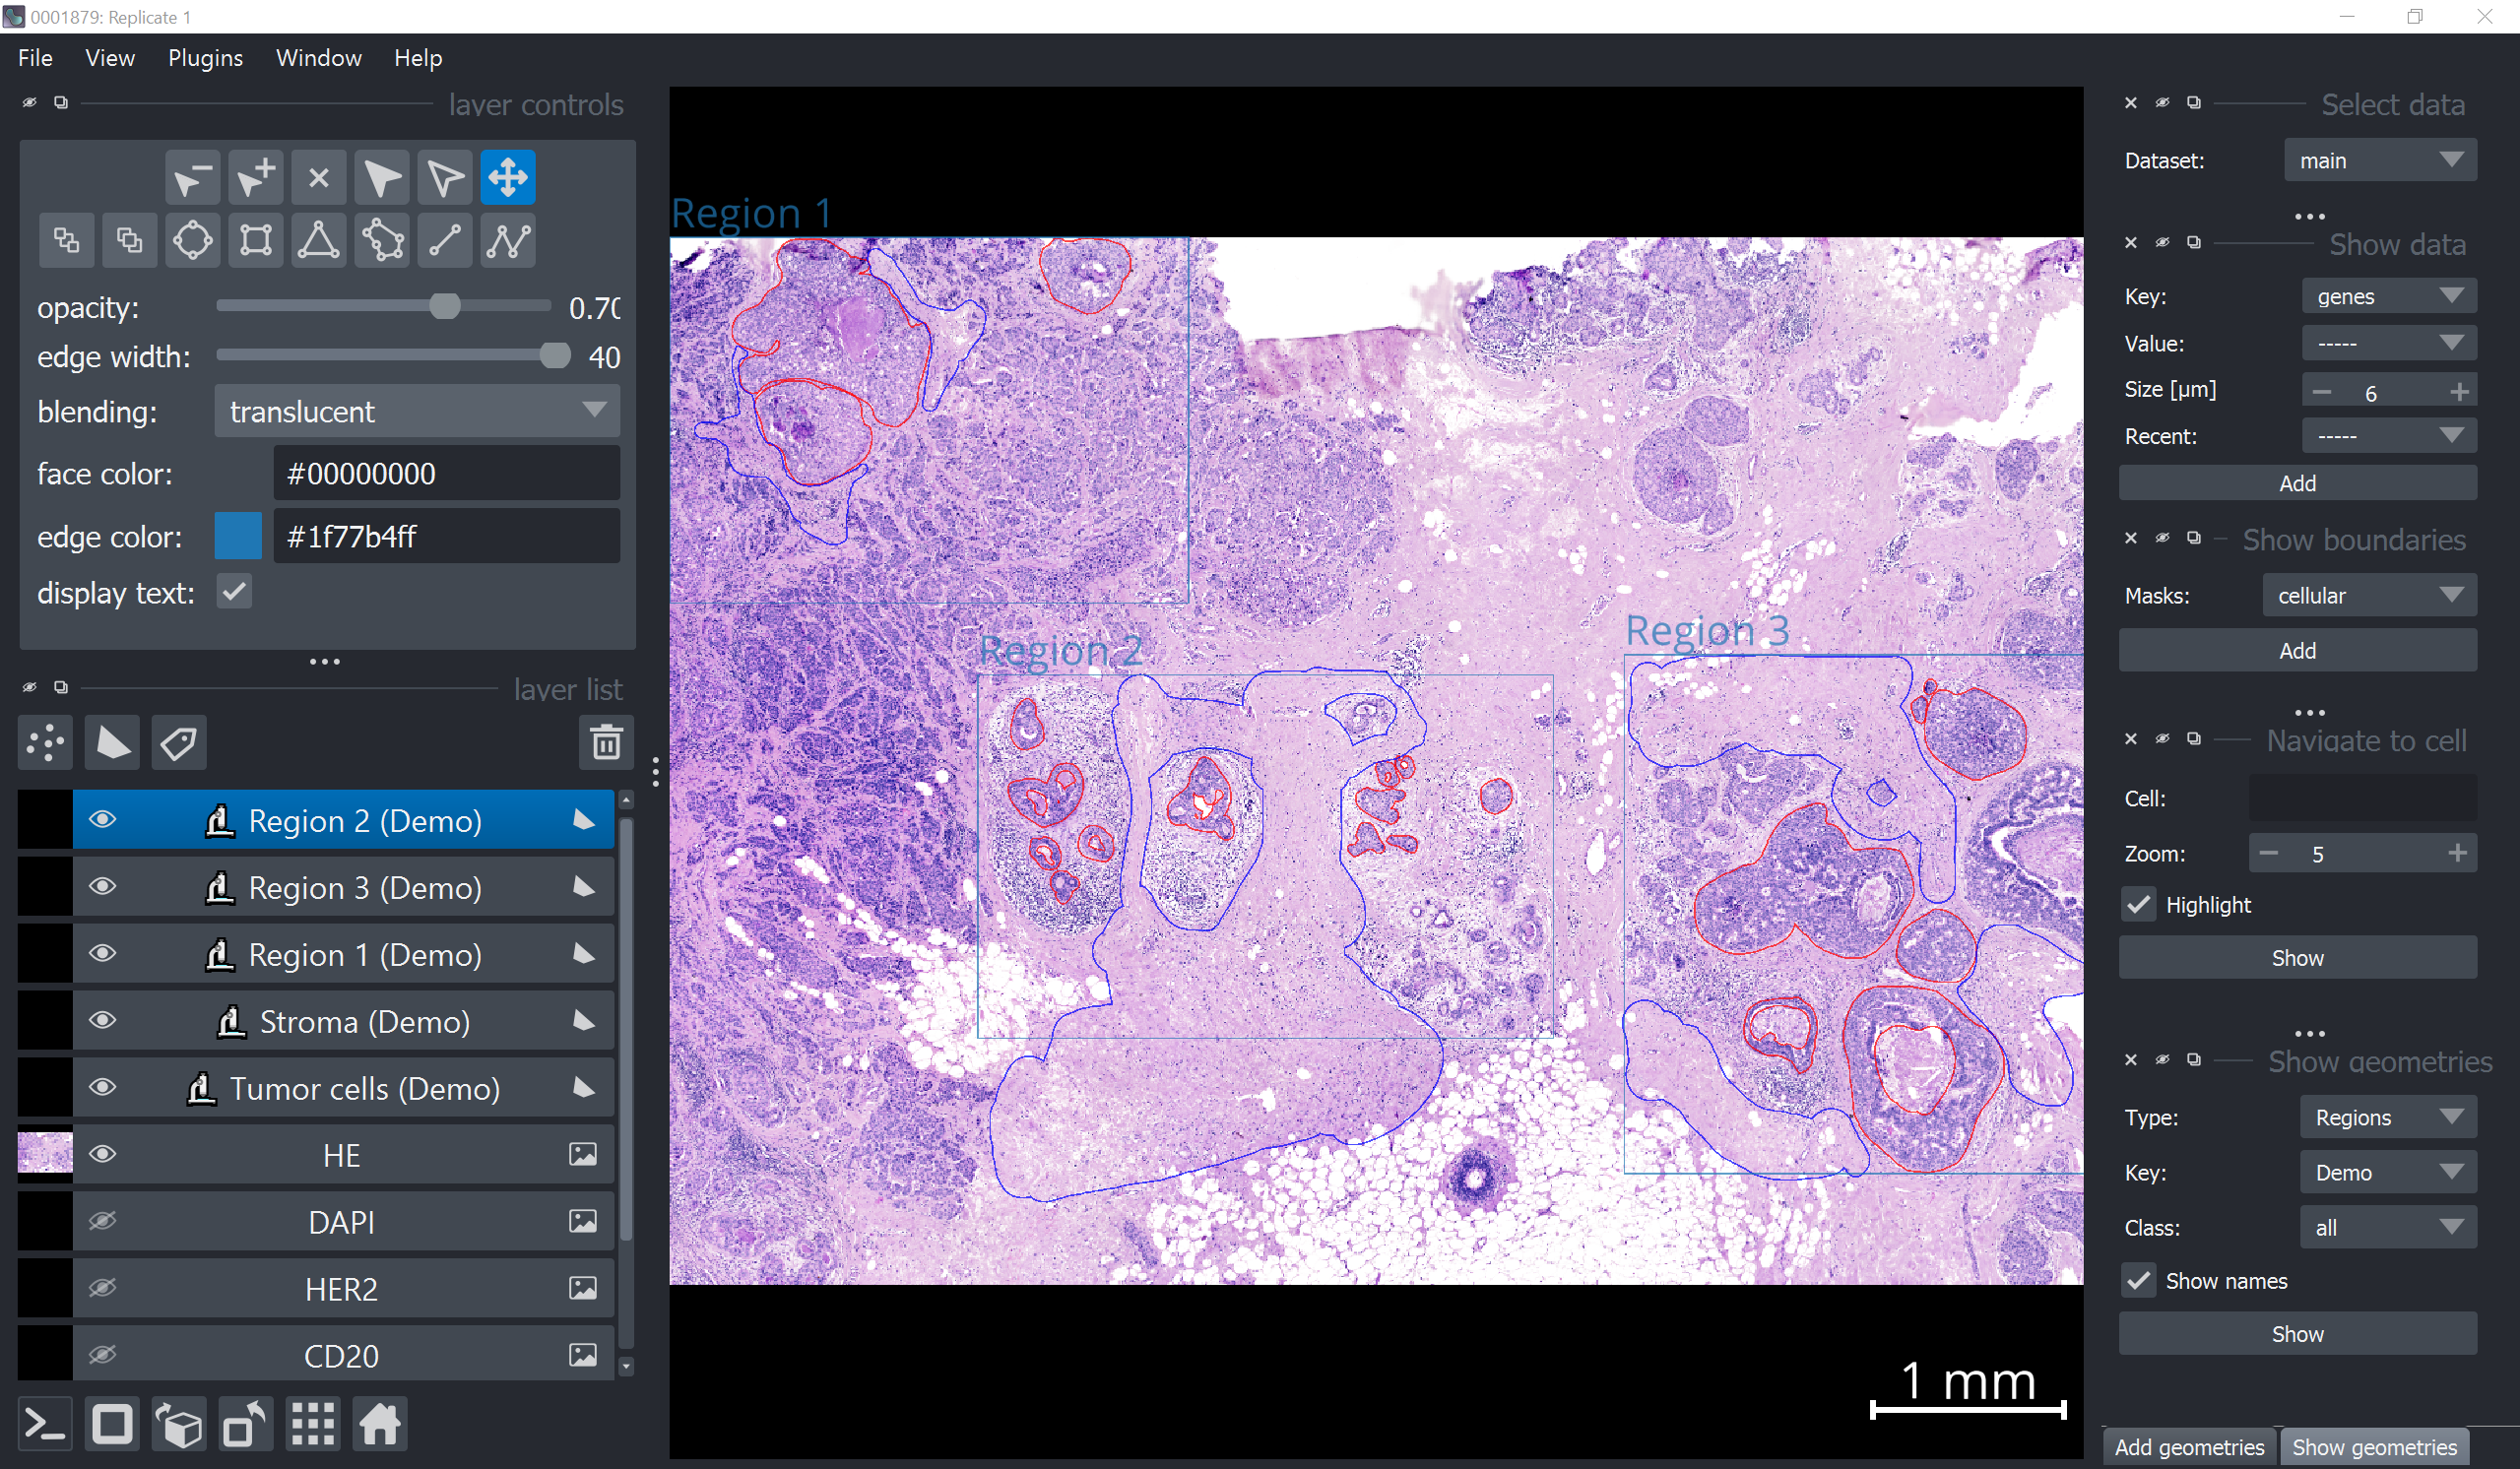

In [10]:
xd.show()

## Perform data-level differential gene expression analysis using `InSituData`

In [11]:
from insitupy import differential_gene_expression

### Scenario 1: Comparison of two annotations within one dataset

Annotations with key 'Demo have already been assigned to `data`.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


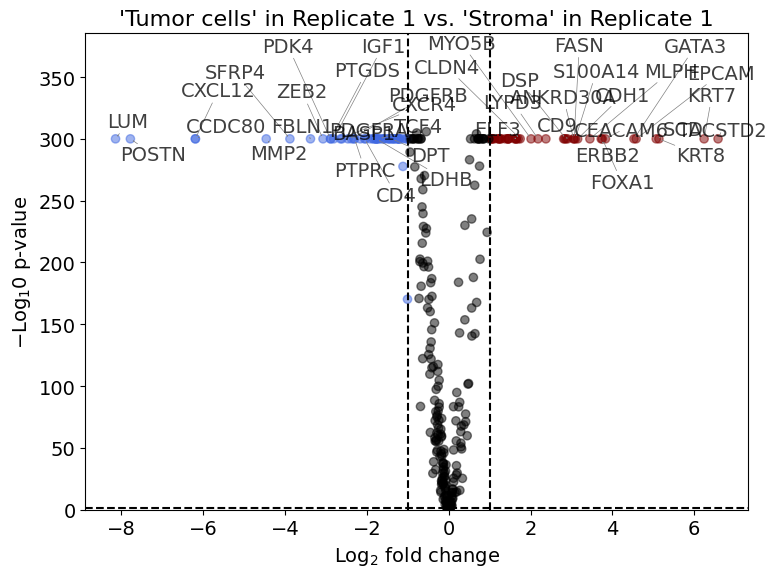

In [12]:
differential_gene_expression(
    data=xd,
    data_annotation_tuple=("Demo", "Tumor cells"),
    ref_annotation_tuple=("Demo", "Stroma"),
    ref_data=None,
    ignore_duplicate_assignments=True # if a cell is assigned to both the annotation and the reference, it is used only for the annotation
)

### Scenario 2: Comparison of two annotations within one dataset - restrict analysis to a specific region

Annotations with key 'Demo have already been assigned to `data`.
Regions with key 'Demo have already been assigned to `data`.
Restrict analysis to region 'Region 3' from key 'Demo'.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


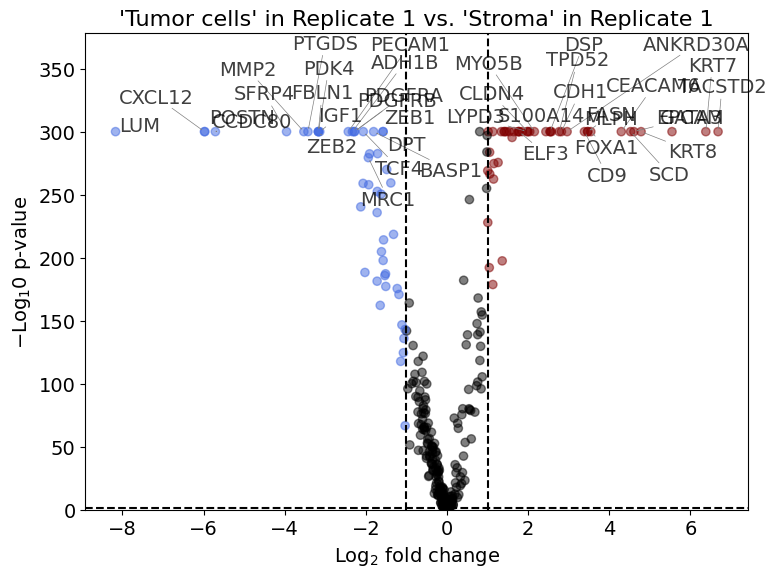

In [13]:
differential_gene_expression(
    data=xd,
    data_annotation_tuple=("Demo", "Tumor cells"),
    ref_annotation_tuple=("Demo", "Stroma"),
    ref_data=None,
    ignore_duplicate_assignments=True, # if a cell is assigned to both the annotation and the reference, it is used only for the annotation
    region_tuple=("Demo", "Region 3"),
)

## Experiment-level differential gene expression analysis

The clear structure of `InSituExperiment` lets us easily plan complex differential gene expression analysis across multiple samples. In the following, different Scenarios are shown how this can be done.

For more information on the `InSituExperiment` object see [here](./09_InSituPy_InSituExperiment.ipynb).

### Creating `InSituExperiment` object

In a first step the region annotations are used to split the dataset and create a `InSituExperiment` object.

In [14]:
from insitupy import InSituExperiment

In [15]:
exp = InSituExperiment.from_regions(
    data=xd,
    region_key="Demo",
    region_names=None # defaults to all regions
)
exp

InSituExperiment with 3 samples:
           uid slide_id    sample_id region_key region_name
0     e1a4e8d4  0001879  Replicate 1       Demo    Region 1
1     13ce78cf  0001879  Replicate 1       Demo    Region 2
2     527be561  0001879  Replicate 1       Demo    Region 3

#### Scenario 1: Comparison of cells within one annotation against all other cells - all within the same dataset

In a second step, the `dge()` function of `InSituExperiment` is used to setup the differential gene expression analysis. This scenario is only uses one dataset but also works on the `InSituExperiment` level. The `name_col` argument can be used to specify which column of the metadata should be used for generating the title.

Annotations with key 'Demo have already been assigned to `data`.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


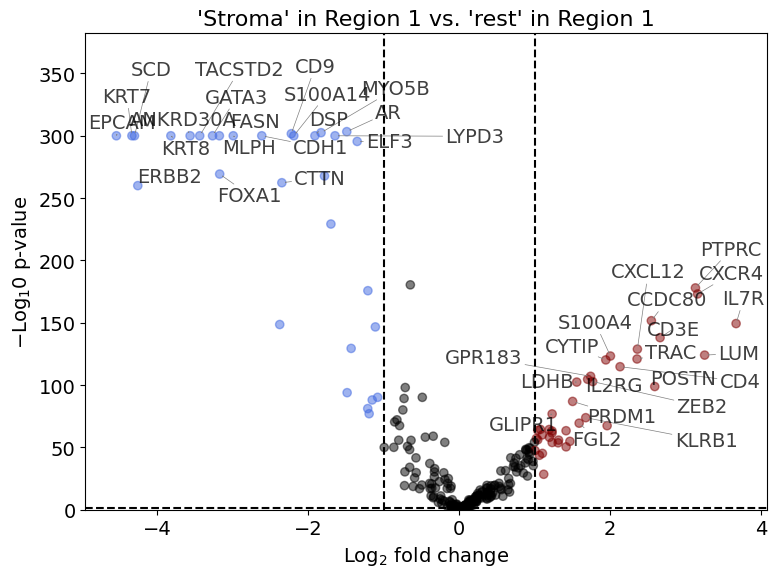

In [16]:
exp.dge(
    data_id=0,
    data_annotation_tuple=("Demo", "Stroma"),
    ref_annotation_tuple="rest",
    name_col="region_name",
)

#### Scenario 2: Comparison of cells within one annotation against all other cells - all within the same dataset but restricted to one cell type

This scenario is very similar to the first but the analysis is restricted to only one cell type (in this case Fibroblasts).

Annotations with key 'Demo have already been assigned to `data`.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


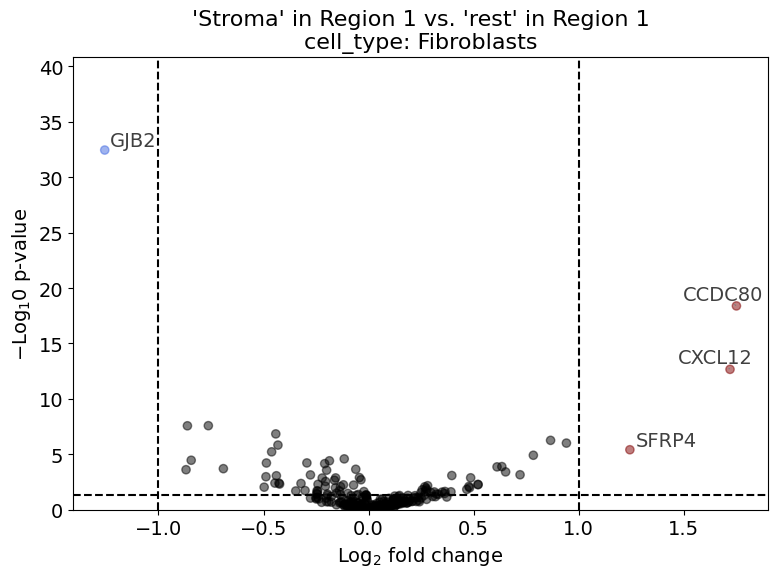

In [17]:
exp.dge(
    data_id=0,
    data_annotation_tuple=("Demo", "Stroma"),
    ref_annotation_tuple="rest",
    obs_tuple=("cell_type", "Fibroblasts"),
    name_col="region_name",
)

#### Scenario 3: Comparison of two annotations between two regions or datasets - restrict analysis to one cell type

This scenario is now the first that is really on the experiment-level by comparing fibroblasts in the stroma region of two samples.

Annotations with key 'Demo have already been assigned to `data`.
Annotations with key 'Demo have already been assigned to `data`.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.
Saving figure to file figures/volcano_demo.pdf
Saved.


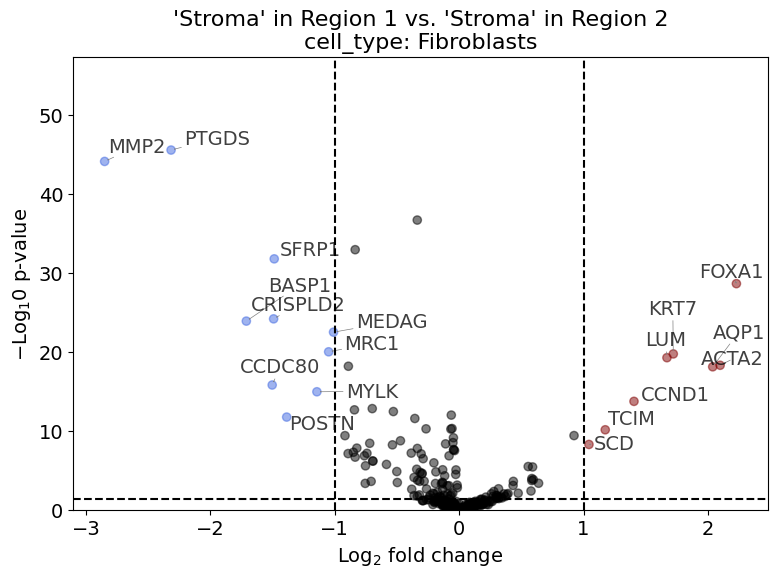

In [18]:
annotation = "Stroma"
cell_type = "Fibroblasts"

exp.dge(
    data_id=0,
    ref_id=1,
    data_annotation_tuple=("Demo", annotation),
    ref_annotation_tuple=("Demo", annotation),
    obs_tuple=("cell_type", cell_type),
    name_col="region_name",
    label_top_n = 10,
    savepath="figures/volcano_demo.pdf"
)

#### Scenario 4: Return results instead of Volcano plot

In [19]:
dge = exp.dge(
    data_id=0,
    ref_id=1,
    data_annotation_tuple=("Demo", annotation),
    ref_annotation_tuple=("Demo", annotation),
    obs_tuple=("cell_type", cell_type),
    plot_volcano=False
)

Annotations with key 'Demo have already been assigned to `data`.
Annotations with key 'Demo have already been assigned to `data`.
Calculate differentially expressed genes with Scanpy's `rank_genes_groups` using 't-test'.


In [20]:
dge.keys()

dict_keys(['results', 'params'])

In [21]:
dge_results = dge['results']

In [22]:
dge['params']

{'groupby': 'combined_annotation_column',
 'reference': '2-Stroma',
 'method': 't-test',
 'use_raw': False,
 'layer': None,
 'corr_method': 'benjamini-hochberg'}

## GO term enrichment analysis

Gene ontology (GO) term enrichment analysis can be performed via three different analysis platforms: [STRINGdb](https://string-db.org/), [g:Profiler](https://biit.cs.ut.ee/gprofiler/gost), and [Enrichr](https://maayanlab.cloud/Enrichr/).

In [23]:
from insitupy.utils.go import GOEnrichment
from insitupy.plotting.go import go_plot

In [24]:
pval_mask = dge_results['pvals'] < 0.05
lfc_mask_up = dge_results['logfoldchanges'] > 1
lfc_mask_down = dge_results['logfoldchanges'] < -1

genes_up = dge_results[lfc_mask_up & pval_mask]['gene'].tolist()
genes_down = dge_results[lfc_mask_down & pval_mask]['gene'].tolist()

In [25]:
# setup go term enrichment class
go = GOEnrichment()

# run go term enrichment analysis for up-regulated genes
go.stringdb(target_genes=genes_up, key_added='up',
             top_n=20, organism="hsapiens", return_df=False
             )
go.gprofiler(target_genes=genes_up, key_added='up',
             top_n=20, organism="hsapiens", return_df=False
             )
go.enrichr(target_genes=genes_up, key_added='up',
             top_n=20, organism="human", return_df=False
             )

# for down-regulated genes
go.stringdb(target_genes=genes_down, key_added='down',
             top_n=20, organism="hsapiens", return_df=False
             )
go.gprofiler(target_genes=genes_down, key_added='down',
             top_n=20, organism="hsapiens", return_df=False
             )
go.enrichr(target_genes=genes_down, key_added='down',
             top_n=20, organism="human", return_df=False
             )

The results are saved in the `GOEnrichment` class and can be accessed with the respective keys.

In [26]:
go

GOEnrichment analyses performed:
  stringdb:
    - up
    - down
  gprofiler:
    - up
    - down
  enrichr:
    - up
    - down

In [27]:
enrichment = go.results["gprofiler"]["down"]
enrichment.head()

source      native                              name   p_value  \
query 0  GO:MF  GO:0008201                   heparin binding  0.000110   
      1  GO:CC  GO:0031012              extracellular matrix  0.000139   
      2  GO:CC  GO:0030312  external encapsulating structure  0.000141   
      3  GO:MF  GO:0005539         glycosaminoglycan binding  0.000424   
      4  GO:MF  GO:1901681           sulfur compound binding  0.000587   

         significant                                        description  \
query 0         True  "Binding to heparin, a member of a group of gl...   
      1         True  "A structure lying external to one or more cel...   
      2         True  "A structure that lies outside the plasma memb...   
      3         True  "Binding to a glycan (polysaccharide) containi...   
      4         True  "Binding to a sulfur compound." [GOC:pr, GOC:T...   

         term_size  query_size  intersection_size  effective_domain_size  \
query 0        176           9                  4                  20212   
      1        555           9                  5                  22097   
      2        556           9                  5                  22097   
      3        247           9                  4                  20212   
      4        268           9                  4                  20212   

         precision  Gene ratio    query                   parents  \
query 0   0.444444    0.022727  query_1  [GO:0005539, GO:1901681]   
      1   0.555556    0.009009  query_1              [GO:0030312]   
      2   0.555556    0.008993  query_1  [GO:0071944, GO:0110165]   
      3   0.444444    0.016194  query_1              [GO:0097367]   
      4   0.444444    0.014925  query_1              [GO:0005488]   

                                  intersections  \
query 0        [POSTN, CCDC80, CRISPLD2, SFRP1]   
      1  [POSTN, CCDC80, CRISPLD2, SFRP1, MMP2]   
      2  [POSTN, CCDC80, CRISPLD2, SFRP1, MMP2]   
      3        [POSTN, CCDC80, CRISPLD2, SFRP1]   
      4        [POSTN, CCDC80, CRISPLD2, SFRP1]   

                                                 evidences  Enrichment score  
query 0                  [[ISS, IEA], [IEA], [IEA], [IDA]]          3.959202  
      1  [[IDA, HDA, ISS, IBA, IEA], [IBA, IEA], [IEA],...          3.855559  
      2  [[IDA, HDA, ISS, IBA, IEA], [IBA, IEA], [IEA],...          3.851703  
      3             [[ISS, IEA], [IEA], [IBA, IEA], [IDA]]          3.372306  
      4                  [[ISS, IEA], [IEA], [IEA], [IDA]]          3.231541

Saving figure to file figures/go_demo.pdf
Saved.


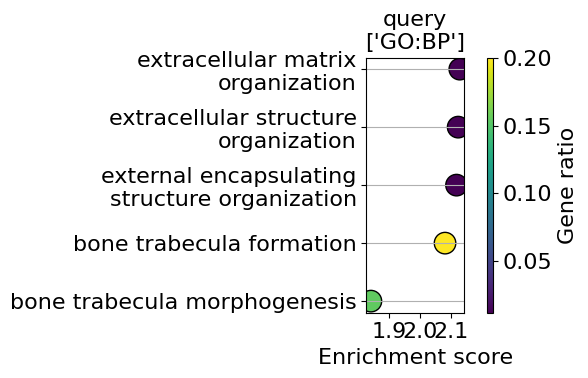

In [28]:
go_plot(enrichment=enrichment,
        style='dot',
        libraries='GO:BP',
        max_to_plot=5,
        figsize=(6,4),
        savepath="figures/go_demo.pdf")